In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.3 MB/s eta 0:00:00:00:01


In [2]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import math

In [3]:
cities = {
    "Seattle": (47.6062, -122.3321),
    "San Francisco": (37.7749, -122.4194),
    "Los Angeles": (34.0522, -118.2437),
    "Phoenix": (33.4484, -112.0740),
    "Denver": (39.7392, -104.9903),
    "Dallas": (32.7767, -96.7970),
    "Chicago": (41.8781, -87.6298),
    "Nashville": (36.1627, -86.7816),
    "Atlanta": (33.7490, -84.3880),
    "Miami": (25.7617, -80.1918),
    "Washington D.C.": (38.9072, -77.0369),
    "New York": (40.7128, -74.0060),
    "Boston": (42.3601, -71.0589)
}

# Generated via chat gpt
metro_populations = {
    "Seattle": 4044000,  # Seattle-Tacoma-Bellevue metro area
    "San Francisco": 4720000,  # San Francisco-Oakland-Hayward metro area
    "Los Angeles": 13204000,  # Los Angeles-Long Beach-Anaheim metro area
    "Phoenix": 5100000,  # Phoenix-Mesa-Scottsdale metro area
    "Denver": 2994000,  # Denver-Aurora-Lakewood metro area
    "Dallas": 7740000,  # Dallas-Fort Worth-Arlington metro area
    "Chicago": 9460000,  # Chicago-Naperville-Elgin metro area
    "Nashville": 2001000,  # Nashville-Davidson-Murfreesboro-Franklin metro area
    "Atlanta": 6067000,  # Atlanta-Sandy Springs-Roswell metro area
    "Miami": 6200000,  # Miami-Fort Lauderdale-West Palm Beach metro area
    "Washington D.C.": 6297000,  # Washington-Arlington-Alexandria metro area
    "New York": 20104000,  # New York-Newark-Jersey City metro area
    "Boston": 4943000  # Boston-Cambridge-Newton metro area
}


city_names = [
    'Seattle',
    'San Francisco',
    'Los Angeles',
    'Phoenix',
    'Denver',
    'Dallas',
    'Chicago',
    'Nashville',
    'Atlanta',
    'Miami',
    'Washington D.C.',
    'New York',
    'Boston'
]


def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 3956 for miles)
    R = 6371.0
    distance = R * c
    
    return distance


In [12]:
#list(metro_populations.keys())

In [39]:
# Randomly generating flows between cities
W_ij = np.zeros((13, 13)) #
#W_ij = np.random.randint(1, 101, (13, 13))


# Initializing a matrix to store transportation costs
C_ij = np.zeros((13, 13))

# Function to compute Euclidean distance
def compute_distance(coord1, coord2):
    return haversine(coord1[0], coord1[1], coord2[0], coord2[1])
    #return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Assign transportation costs based on distances
for idx1, city1 in enumerate(cities):
    for idx2, city2 in enumerate(cities):
        distance = compute_distance(cities[city1], cities[city2])
        # Assuming $10 per unit distance for transportation cost
        C_ij[idx1, idx2] = distance * 10

        if city1 != city2:
            W_ij[idx1, idx2] = (metro_populations[city1] + metro_populations[city2] ) / distance**2
        


In [40]:
# Assuming hub construction costs ranging between $100M to $500M
f_k = {city: np.random.randint(100, 501) for city in cities}

#there's a 20% discount on trunk transport between hubs.
alpha = 0.8

In [47]:
pd.DataFrame(W_ij, columns=cities.keys(), index=cities.keys())

,Seattle,San Francisco,Los Angeles,Phoenix,Denver,Dallas,Chicago,Nashville,Atlanta,Miami,Washington D.C.,New York,Boston
Seattle,0.000000,7.333177,7.222873,2.842461,2.614398,1.612485,1.736240,0.601119,0.822714,0.530073,0.740780,1.616082,0.561668
San Francisco,7.333177,0.000000,57.335550,8.893200,3.319120,2.193716,1.591529,0.676484,0.913207,0.628058,0.717486,1.456008,0.514519
Los Angeles,7.222873,57.335550,0.000000,55.503461,9.081611,5.278206,2.882633,1.860069,1.992005,1.373409,1.430649,2.150277,1.043793
Phoenix,2.842461,8.893200,55.503461,0.000000,9.114886,6.336253,2.667405,1.316785,1.708382,1.114183,1.125198,2.125296,0.736101
Denver,2.614398,3.319120,9.081611,9.114886,0.000000,9.440528,5.703402,1.852279,2.389380,1.192633,1.617693,3.367325,0.983169
Dallas,1.612485,2.193716,5.278206,6.336253,9.440528,0.000000,10.256966,9.905023,10.294577,4.367049,3.879187,5.723056,2.040527
Chicago,1.736240,1.591529,2.882633,2.667405,5.703402,10.256966,0.000000,28.005149,17.295098,4.259976,17.270294,22.578237,7.722907
Nashville,0.601119,0.676484,1.860069,1.316785,1.852279,9.905023,28.005149,0.000000,67.458622,4.740413,9.993021,14.832997,3.022772
Atlanta,0.822714,0.913207,1.992005,1.708382,2.389380,10.294577,17.295098,67.458622,0.000000,12.880800,16.232857,18.164713,4.851855
Miami,0.530073,0.628058,1.373409,1.114183,1.192633,4.367049,4.259976,4.740413,12.880800,0.000000,5.620146,8.511443,2.716487


In [48]:
# Given Data
I = list(range(13))  # Set of nodes, considering 13 cities
P = 4  # Number of hubs

# Model Initialization
m = gp.Model("HubAndSpoke")

# Decision Variables
Y_ik = m.addVars(I, I, vtype=GRB.BINARY, name="Y_ik")
Y_kk = m.addVars(I, vtype=GRB.BINARY, name="Y_kk")

# Objective Function
obj = gp.quicksum(W_ij[i][j] * (C_ij[i][k] * Y_ik[i,k] + alpha * C_ij[k][l] * Y_ik[k,l] + C_ij[l][j] * Y_ik[l,j]) for i in I for j in I for k in I for l in I) + gp.quicksum(f_k[city] * Y_kk[k] for city, k in zip(cities, I))
m.setObjective(obj, GRB.MINIMIZE)

# Constraints
# Constraint 1: Each non-hub node can only be assigned to 1 hub node
for i in I:
    m.addConstr(gp.quicksum(Y_ik[i,k] for k in I) == 1)

# Constraint 2: Limit the number of hub nodes to P
m.addConstr(gp.quicksum(Y_kk[k] for k in I) == P)

# Constraint 3: We cannot assign a non-hub node to a hub node unless we open it
for i in I:
    for k in I:
        m.addConstr(Y_ik[i,k] <= Y_kk[k])

# Solve Model
m.optimize()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 183 rows, 182 columns and 520 nonzeros
Model fingerprint: 0x73783c2c
Variable types: 0 continuous, 182 integer (182 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 1.596476e+09
Presolve time: 0.00s
Presolved: 183 rows, 182 columns, 520 nonzeros
Variable types: 0 continuous, 182 integer (182 binary)
Found heuristic solution: objective 3.543702e+08

Root relaxation: objective 3.275628e+08, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

In [49]:
# Print Results
if m.status == GRB.OPTIMAL:
    print('Optimal Objective Value: ', m.objVal)
    hubs = [k for k in I if Y_kk[k].x > 0.5]
    print('Optimal Hub Locations (indexes): ', hubs)
    assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}
    print('Assignments: ', assignments)

Optimal Objective Value:  327562824.1294548
Optimal Hub Locations (indexes):  [1, 4, 7, 11]
Assignments:  {(0, 1): 1.0, (1, 1): 1.0, (2, 1): 1.0, (3, 4): 1.0, (4, 4): 1.0, (5, 4): 1.0, (6, 7): 1.0, (7, 7): 1.0, (8, 7): 1.0, (9, 7): 1.0, (10, 11): 1.0, (11, 11): 1.0, (12, 11): 1.0}


In [50]:
# Results can be changed as we used random numbers

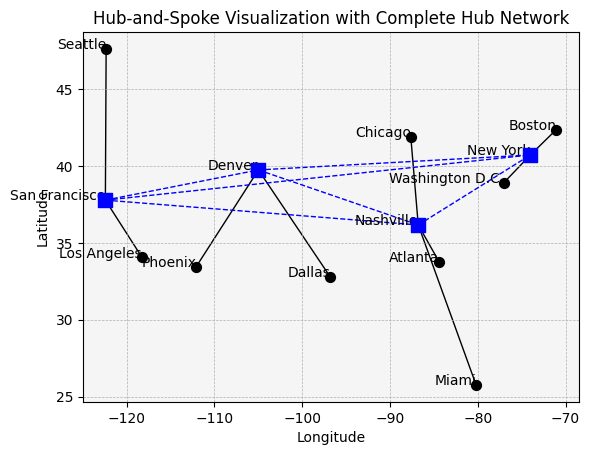

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

# Extract Results
hubs = [k for k in I if Y_kk[k].x > 0.5]
assignments = {(i,k): Y_ik[i,k].x for i in I for k in I if Y_ik[i,k].x > 0.5}

# Plot Cities and Hubs
for idx, city in enumerate(cities):
    if idx in hubs:
        plt.scatter(cities[city][1], cities[city][0], color='blue', s=100, zorder=5, marker='s')
        plt.text(cities[city][1], cities[city][0], city, fontsize=10, ha='right')
    else:
        plt.scatter(cities[city][1], cities[city][0], color='black', s=50, zorder=5)
        plt.text(cities[city][1], cities[city][0], city, fontsize=10, ha='right')

# Draw Assignments
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        plt.plot([cities[city_i][1], cities[city_k][1]], [cities[city_i][0], cities[city_k][0]], 'k-', lw=1, zorder=1)

# Create Complete Graph Among Hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            plt.plot([cities[city1][1], cities[city2][1]], [cities[city1][0], cities[city2][0]], 'b--', lw=1, zorder=2)

plt.title("Hub-and-Spoke Visualization with Complete Hub Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.show()
plt.savefig("hub_and_spoke_visualization.png", dpi=300)  

In [34]:
import folium

# Initial map centered around the United States
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Plot hubs (in blue) and non-hubs (in black)
for idx, city in enumerate(cities):
    if idx in hubs:
        folium.Marker(
            location=cities[city],
            icon=folium.Icon(color='blue', icon='cloud'),
            popup=city
        ).add_to(m)
    else:
        folium.Marker(
            location=cities[city],
            popup=city
        ).add_to(m)

# Draw lines connecting non-hubs to their hubs
for (i, k), v in assignments.items():
    if v > 0.5:
        city_i = list(cities.keys())[i]
        city_k = list(cities.keys())[k]
        folium.PolyLine([cities[city_i], cities[city_k]], color="black").add_to(m)

# Create lines to represent the complete graph among hubs
for idx1, hub1 in enumerate(hubs):
    for idx2, hub2 in enumerate(hubs):
        if idx1 < idx2:
            city1 = list(cities.keys())[hub1]
            city2 = list(cities.keys())[hub2]
            folium.PolyLine([cities[city1], cities[city2]], color="blue", dash_array="5, 5").add_to(m)




In [35]:
# Display the map
m